# Goal of the project
The goal of this project is to lein_valuern a policy for an inverted pendulum model to make it do a swing-up motion. Beyond the task of inverting a pendulum, the goal is to also gain an understanding on how Q-learning works, its limitations and advantages.

To make the problem interesting, the inverted pendulum has a limit on the maximum torque it can apply, therefore it is necessary for the pendulum to do a few "back and forth" motions to be able to reach the inverted position ($\theta=\pi$) from the standing still non-inverted position ($\theta=0$). 

<img src='pendulum.png' width="120">

In the following, we will write $x = \begin{pmatrix} \theta \\ \omega \end{pmatrix}$ as the vector of states of the system. We will also work with time-discretized dynamics, and refer to $x_n$ as the state at time $t = n \Delta t$ (assuming discretization time $\Delta t$)

We want to minimize the following discounted cost function
$$\sum_{i=0}^{\infty} \alpha^i g(x_i, u_i)$$ where 
$$g(x_i, u_i) = (\theta-\pi)^2 + 0.01 \cdot \dot{\theta}_i^2 + 0.0001 \cdot u_i^2 \qquad \textrm{and} \qquad\alpha=0.99$$
This cost mostly penalizes deviations from the inverted position but also encourages small velocities and control.

## Q-learning with a table
In the first part, we will implement the Q-learning algorithm with a table. To that end, we are given a robot (defined in the package ```pendulum.py```) with a function ```get_next_state(x,u)``` that returns $x_{n+1}$ given $(x_n, u_n)$. We will assume that $u$ can take only three possible values. Note that $\theta$ can take any value in $[0,2\pi)$ and that $\omega$ can take any value between $[-6,6]$. 

In order to build the table, we will need to discretize the states. So for the learning algorithm we will use 50 discretized states for $\theta$ and 50 for $\omega$. Keep in mind that the real states of the pendulum used to generate an episode will not be discretized.


1. Write a function ```get_cost(x,u)``` that returns the current cost $g(x,u)$ as a function of the current state and control.

2. What is the dimension of the Q-table that you will need to implement (as a numpy array)? Why?

3. How can you compute the optimal policy from the Q-table? And the optimal value function? Write a function ```get_policy_and_value_function(q_table)``` that computes both given a Q-table as an input.

4. Write a function ```q_learning(q_table)``` that implements the tabular Q-learning algorithm (use episodes of 100 timesteps and an epsilon greedy policy with $\epsilon=0.1$). The function should get as an input an initial Q-table  and return a learned Q-table of similar size. Use the function ```get_next_state``` from the pendulum package to generate the episode (do not discretize the real state of the pendulum!). During learning store the cost per episode to track learning progress.

5. How many epsilodes (approximately) does it take for Q-learning to learn how to invert the pendulum when $u \in \{-4,0,4\}$? (use a learning rate of 0.1). Show the learning progress in a plot.

6. Using the simulate / animate functions (cf. below) how many back and forth of the pendulum are necessary to go from $x = [0,0]$ to the fully inverted position? Plot the time evolution of $\theta$ and $\omega$. 

7. Plot the found policy and value function as 2D images (cf. below).

8. Answer questions 5 to 7 when using $u \in \{-5,0,5\}$. What quantitative differences do you see between the computed policies in 5. and 8.? Can you explain?

9. How is learning affected when changing $\epsilon$ and the learning rate? Why?

In [1]:
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import random

import pendulum

In [2]:
def get_cost(x,u):
    cost = 0
    cost = (x[0]-np.pi)**2 + 0.01*(x[1]**2) + 0.0001 *(u**2)
    return cost


In [3]:
# we don't want 2pi to be in the set because it's the same as 0
# we generate 50 equally spaced points for theta
discretized_theta = np.linspace(0, 2*np.pi, 50, endpoint=False)

# we generate 50 equally spaced points for omega
discretized_omega = np.linspace(-6, 6, 50)

# now given an arbitrary continuous state theta
theta_arbitrary = 0.6234
omega_arbitrary = 1.234

# we can find the index of the closest element in the set of discretized states
index_in_discretized_theta = np.argmin(np.abs(discretized_theta - theta_arbitrary))
index_in_discretized_omega = np.argmin(np.abs(discretized_omega - omega_arbitrary))

# and find the closed discretized state
closest_theta_state = discretized_theta[index_in_discretized_theta]
closest_omega_state = discretized_omega[index_in_discretized_omega]

print(f'the discretized theta closest to {theta_arbitrary} is {closest_theta_state} with index {index_in_discretized_theta}')
print(f'the discretized omega closest to {omega_arbitrary} is {closest_omega_state} with index {index_in_discretized_omega}')

the discretized theta closest to 0.6234 is 0.6283185307179586 with index 5
the discretized omega closest to 1.234 is 1.3469387755102042 with index 30


In [4]:
def get_policy_and_value_function(q_table):
    
    value_fn = np.zeros((50,50))
    policy = np.zeros((50,50))
    
   
    for i in range(len(discretized_theta)):
        for j in range(len(discretized_omega)):
            
         in_value = Q_table[0][i][j]
         Q_con = 0
         for k in range(len(u_con)):
             if in_value > Q_table[k][i][j]:
                 in_value = Q_table[k][i][j]
                 Q_con = k
                    
         value_fn[i,j] = in_value
         policy[i,j] = u_con[Q_con]

        
            
    return value_fn,policy

In [5]:
def index(x):

    theta_in = np.argmin(np.abs(discretized_theta - x[0]))
    omega_in = np.argmin(np.abs(discretized_omega - x[1]))
    
    return theta_in,omega_in

In [6]:
def q_learning(Q_table):
    x0 =x
    curr_cost=0
    for l in range(100):
        Q_t = Q_table.copy()
        i, j = index(x0)
        act = Q_t[0,i,j]
        Q_u = 0
        
        for u in range(len(u_con)):
            if act > Q_t[u,i,j]:
                act = Q_t[u,i,j]
                Q_u = u     
        act = [Q_u, random.choice(range(len(u_con)))]
        dist = [1-e, e]
        k = random.choices(act,dist)[0] 
        x_next = pendulum.get_next_state(x0,u_con[k])
        i_new, j_new = index(x_next)
        Q_table[k,i,j] = Q_t[k,i,j] + gamma * (get_cost(x0,u_con[k])+alpha*(min((Q_t[a,i_new,j_new]) for a in range(3))) - Q_t[k,i,j])
        x0 = x_next
        curr_cost += get_cost(x0,u_con[k])
 

    return Q_table,curr_cost

In [7]:
e = 0.1
gamma = 0.1
alpha = 0.99
x = np.array([0.,0.])
u_con = np.array([-4,0,4])
Q_table = np.zeros([3,50,50])
curr_cost_l = []
episodes = 6000
for l in range(episodes):
    Q_table,curr_cost = q_learning(Q_table)
    curr_cost_l.append(curr_cost)

value_fn,policy = get_policy_and_value_function(Q_table)

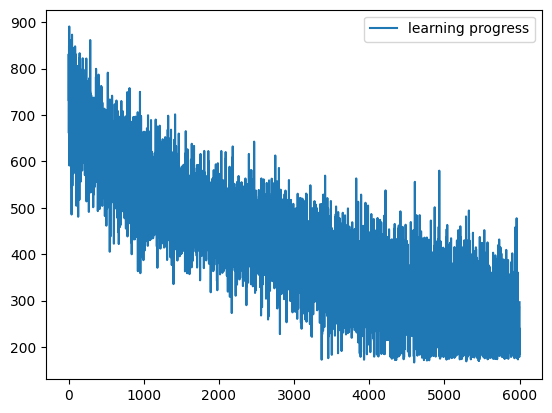

In [8]:
b =np.asarray(curr_cost_l)
plt.figure()
xv = np.linspace(0,episodes,episodes)
plt.plot(xv,b)
plt.legend(['learning progress'])
# xv.size


In [9]:
# we can also simulate the robot but we need to provide a controller of the following form
def dummy_controller(x):
    """
        the prototype of a controller is as follows
        x is a column vector containing the state of the robot
        
        this controller needs to return a scalar
        you may want to modify this controller to use the policy table to compute control output
    """
    # here we do nothing and just return a 0 control

    theta_index = np.argmin(np.abs(discretized_theta - x[0]))
    omega_index = np.argmin(np.abs(discretized_omega - x[1]))

    return policy[theta_index, omega_index]


# we can now simulate for a given number of time steps - here we do 10 seconds
T = 10.
x0 = np.array([0,0.])

t, x, u = pendulum.simulate(x0, dummy_controller, T)

Text(0.5, 0, 'Time [s]')

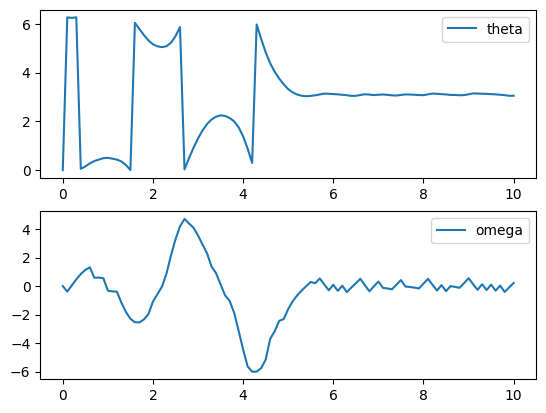

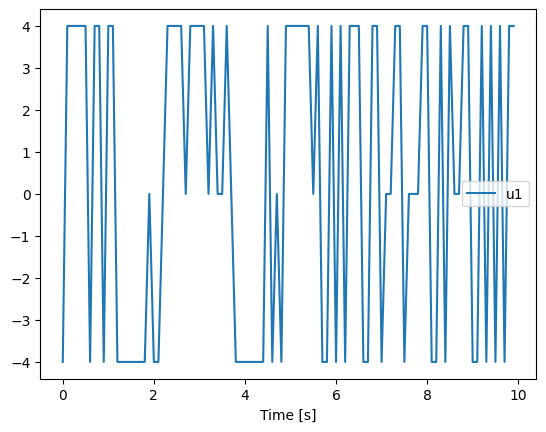

In [10]:
# we can plot the results
plt.figure()

plt.subplot(2,1,1)
plt.plot(t, x[0,:])
plt.legend(['theta'])

plt.subplot(2,1,2)
plt.plot(t, x[1,:])
plt.legend(['omega'])

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1'])
plt.xlabel('Time [s]')

In [11]:
# now we can also create an animation
pendulum.animate_robot(x)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAlBhtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwMiA0MTZlM2ViIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMiAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE4
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DRVliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCLH/2+kONwAT9lg/NYjL/FoB9aiK4jE+YrYPvM3VJY4vjNnyLGP2YlbJp/NpA8k+C6YwpDlXn2f
y1TN9QNLS2doYg16nA3KBIICjrY2PQjGG/lJWgkVRima9js6Vx5WimbQrt72ItjNL7sLxElEA17m
hCeWbA7zyXROB8c1qwBwG6mF4Z9p4RctmYdY75fZ9PIcL6+1DtNo159DsIedHWW5BeeoUeMIr4lP
ZQqSz5JJC7+UNk320iVM7FJjmHG6sJrpM/dh0nQ+5r39OQ6RmVrVK1PYH+AOycAUF/b9pFk95XFX
RxCqPJ0AVrNvSkCKxJc2DnGq23y1nGBZ127xxqpU/igQ6yAFvguNC7oG/xZGBYBEohvF6/LewX2a
A+aHL9961Ual9N+JPaEdVqNgZLba5T918fBue/HVYXY24KxL10ijCur/Qlv/AcWwji9ew7mbPIPk
hB4sbRpm2Il9JEqlOnxBFjtq/wKfkNJeUSf9J5P8O4BNTkM1gkZL/wyhJYvT1X0K+Jk0axfEEQyC
iTH7hzm/SxzoncYZIn5BZ8sxRAWesZ+pg7wAFlsTZOi+X9u9nLEzMBtt4zEEgZ+C32PDnZae+ds5
LBI6r/3k2snwp8XCTodng4fYqDVUOgBRMgSMWF09Rjss95a5Zq+j+Yax4Lz7PlABc7azzgAAAwJY
YKOVNMrl6KL56PFo+XNAOJFYk5sHzZRaw9tq65pGNPkyV48tmLE4MR/lYy1BluJ2nSlIFkKgzH50
QXZXMTqb7pdBAMlFlP9AA2i74xZrzWA0Q4OFx4Bb1n/JvrZyxbFQnwWW/v8oPkxv2wXuScDxcgUb
twq5qVH1xf4C+82wLdzNPCoPxP7VBPizkRCgEUI+s1TnIxkPhTM2T0n8ysjIZBi5xRXZVsNGq0Gb
KTz1p8GsMLVOBN5wsZ58REFlh3kQCbgOf/LA+DFXUOi7qxcf0YTuMiPLVRDoEQspo+vmnom2sZ7+
ZCrur6X3ow8bT6WM/Mgzein/6JydwqlEOPpQts4ZJw0Li4uuFRbFKM3cs6DmvEDljpcwCTJrpwl+
3HxGi21mXJ4crF6XflhojcHoLZQNFsTQarP2zoSG7YVyg7gVWSuhW0XZ79CS/kGJnllsLJahewyT
Xr1uSyJ4NrjcqPX0efsefTEhOlTYoSNHtIKNLavE+2AP95Hd2EkPlDbBe79z2sK2GzWNHIZ5KoTB
XE7sZs3X39ul0Rr1O9mWFyxUWyA5XplCcOVZNENClWtOqfp0RnohDiyemJ7Mr2fyvoio0DH1TQ4F
bwXwrYG2r84iG6k2loU5XObNAX21z6j6aCsOaps3mIX5EgXoG2Ft1MmKhnTtvJ9c+x9kH/kqezHv
hnAuSvahzpNIQgQ8dtoSdUcA4T+xgcQJpJmzAE/SKnPB62O/nNI0Dr6f93D5whuwmYs6am722swm
6G8KVPIYVRV0auHCvBJZWLox/Tc3Ct9G101GmnAApKXaRcKn5OobspkoTqdOQTgj9QgRsHl06XsN
WExqIyPDmMVoFgybJACTu9wgF/I4meqqWhNYO3rmHN6ThgMpxVO3e4z/bRqCSV+K5b4v/GkBPqbA
V0NY0hywkSS74TOUe4U7s1pM4ALqjyRfyVy5nqBFlAURFmTF7nwG3umZDxjWbdyr3bIRTMIVP4zg
WU4kmOg8nE9v0PWcLM4eQfZCdE88GLeckp1UJ9H3B7BNowU+eGJJ73/Tlf98QmZteeDaTokxeFs9
y6dkm/0PZjvZqdS7/2qNxT725JzPPDLSTSJA1sGhDp7J/PSkB57qkmypc0UXOwXfj598LXVKlxuM
pggMc096Km20seDZjmijfmILjYo4/jj7UXFofUQx9hkC69WWtvYrfSsb98Akjnyejc+L9/9U41mi
zZDi9hax5zaVl3NXUlzCyQqGUmoa9o6AmVIJi71SLsq2T3m+szeRpMoNAo4TxBWOIjL6RrZfAIOW
NP/NJ8pavgra53yMYwRh/b2hzPK+q+yVPfeV3AZE19yZFWMnddM/SLF/Ud3wfifTiCZrb49WwN3R
Qo6Oxj2eG4z1P/ZV33shBuqTLBm+DPLVNSD2j/Pr2cix6tBF3oK/5C2xu4xgkJWhD3jV//a4QTyP
oIO7dY/YvYgG/rn17e+6kaFD9IAb6fukTXnz7Egaw3u3zFjYG7Nug6kR5Oa7+etMSVE2NOIO0hhE
fc6ic98XnW5k7yBHNoGWMOrgcdhkaS98g69n1FI5Tx9ZpjDIr8wZsPt9ig3sX30EQre2o0uGyOMp
+D9/H88Qyfcln68tUraKGyv0QAAErO8rWEWxvwD+j3qpDYUHjL7Ch9jgxYglLi3wnEUq/480DOHq
7zGhj1B98zxEQrnjMOFtA9dpL7zpaqt1XYDlK9ElkBIFir1png3XpQ0sx7U611uVZT98xu/YfI9V
LttTODokYoxITj6Aat3v7FswqgI/q8V7Zm3eFK14YqM6vWPPhjuPBjqpb3mJyWInR0j/zoI2+L+A
+9e3ez+wamwXREzCsaUKuzecVjXD94WflPNLpHOj0kKbN+z9euoexKj+WYrXF+XZbR+3sob4m583
4CAzNAWuc9Zy2ZqcRm4UECCree0CfZprZ9oQhC8sSOgHLvCyNN+Cdo/gU1bvOOUvTSSSDbrxcE3J
G1M32YySP0FLh9ln+SNx/icSALFya9zHpu39iydzT4Ur0mS90heb7/I4kQHXRWk9YrR47kPyKIf+
8HxEumbQtWOFnC+9I4IhfD45e0oQTQBoJGRPjVb3DT8+D2+GEKa7JhJpKwhik3j3H7gNJbnWgaXT
pcB25IB0fRGwcJfVqq9a7

We also need to discretize the state space, we discretize $\theta \in [0, 2\pi]$ in 50 states and $\dot{\theta} \in [-6, 6]$ is 50 states. For example:

Text(0.5, 1.0, 'Policy')

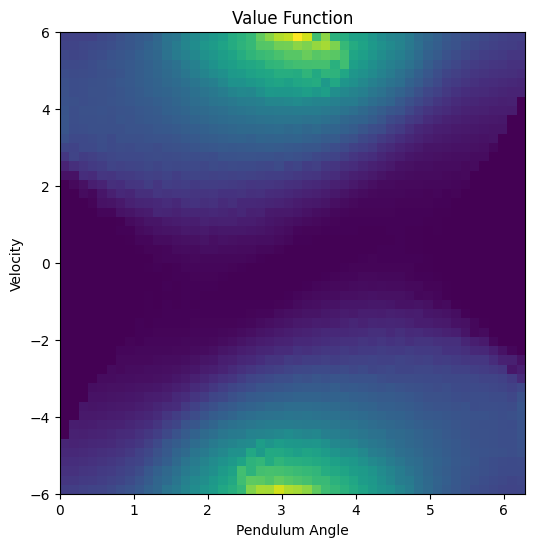

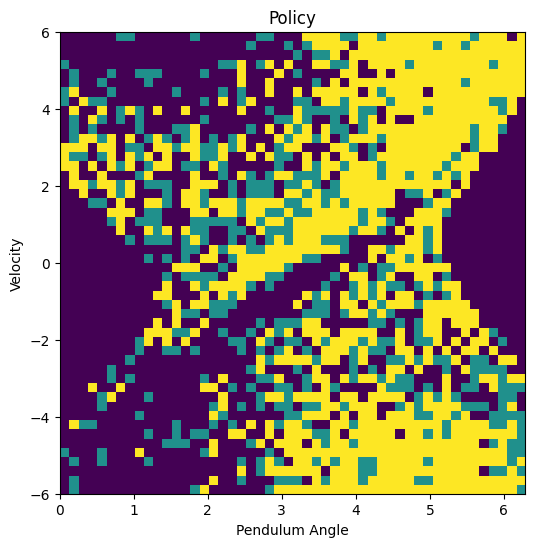

In [12]:
# here is some code to plot results, assuming a policy and a value function are given
# this can be used to answer questions in both Part 1 and 2

value_function = value_fn
# policy = np.zeros([50,50])

# we plot the value function
plt.figure(figsize=[6,6])
plt.imshow(value_function, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')

# we plot the policy
plt.figure(figsize=[6,6])
plt.imshow(policy, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')